In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from typing import *
from sensetools.plots import feature_labeller

In [2]:
from scipy.stats import spearmanr
from collections import defaultdict

In [3]:
protein = '1fme'

In [4]:
summary_paths = [f'../{protein}/summary_batch1.h5', f'../{protein}/summary_batch2.h5']
vamp_eqs = []
for summary_path in summary_paths:
    vamp_eqs.append(pd.read_hdf(summary_path, key='vamp_eqs'))
vamp_eqs = pd.concat(vamp_eqs)
# vamp_eqs.reset_index(inplace=True)

In [5]:
vamp_eqs['rank'] = vamp_eqs.groupby(['lag', 'process'])['median'].rank(ascending=False)

In [6]:
def spearmans(df: pd.DataFrame, proc: int, top: int = 95) -> pd.DataFrame: 
    lags = df.lag.unique()
    n_lags = len(lags)
    results = defaultdict(list)
    if top == -1: 
        top = df['rank'].max()
        
    for i in range(n_lags):
        i_lag = lags[i]
        i_keep_ix = df.loc[(df['rank'] <= top) & (df.lag == i_lag) & (df.process == proc), 'hp_ix'].values
        ps = []
        for j in range(n_lags): 
            i_lag, j_lag = lags[i], lags[j]
            
            j_keep_ix = df.loc[(df.lag == j_lag) & (df.process == proc), 'hp_ix']
            keep_ix = set(i_keep_ix).intersection(set(j_keep_ix))
            
            a = df.loc[(df.lag == i_lag) & (df.process == proc) & (df.hp_ix.isin(keep_ix)), 'median'].values
            b = df.loc[(df.lag == j_lag) & (df.process == proc) & (df.hp_ix.isin(keep_ix)), 'median'].values
#             print(len(a), len(b))
            r, p = spearmanr(a, b)
            ps.append(p)
            results['i_lag'].append(i_lag)
            results['j_lag'].append(j_lag)
            results['r'].append(r)
#         print(np.mean(p)>0.05)
    df = pd.DataFrame(results)
    df = df.pivot_table(values='r', index='i_lag', columns='j_lag')
    return df

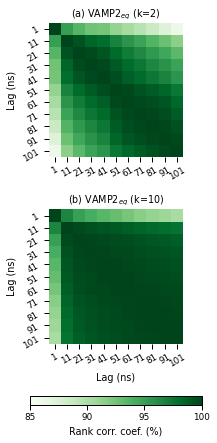

In [18]:
with sns.plotting_context('paper', font_scale=1):
    gs_kw = dict(width_ratios=[1], height_ratios=[3, 3, 0.2], hspace=0.1)
    fig, axd = plt.subplot_mosaic([['top'],
                                   ['bottom'], 
                                   ['cbar']],
                                  gridspec_kw=gs_kw, figsize=(3, 6),
                                  constrained_layout=True )
    vmin, vmax = 85, 100
    procs = [2, 10]
    top_n = -1
    for i, lab in enumerate(['top','bottom']):
        ax = axd[lab]
        proc = procs[i]
        
#         plt.setp(ax.xaxis.get_majorticklabels(), rotation=70 )
#         plt.setp(ax.yaxis.get_majorticklabels(), rotation=70 )

        
        df = spearmans(vamp_eqs, proc, top_n)


        sns.heatmap(df*100, ax=ax, vmin=vmin, vmax=vmax, annot=False, cmap='Greens', cbar=False, 
                    annot_kws=dict(size='small'), square=True, fmt='0.1f')
        
        if lab in ['bottom']:
            ax.set_xlabel('Lag (ns)')
        else: 
            ax.set_xlabel('')
        ax.set_ylabel('Lag (ns)')
        ax.set_title(f"({list('abcd')[i*1+j]}) VAMP2$_{{eq}}$ (k={proc})")
        
        ax.tick_params(axis='x', rotation=30)
        ax.tick_params(axis='y', rotation=30)      
        
    col_map = plt.get_cmap('Greens')
    mpl.colorbar.ColorbarBase(axd['cbar'], cmap=col_map, orientation = 'horizontal', 
                             label='Rank corr. coef. (%)', norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))  
    
    
    
    
#     plt.tight_layout()
    plt.savefig(f'../{protein}/vampeq_rank_vs_lag.pdf', bbox_inches='tight')

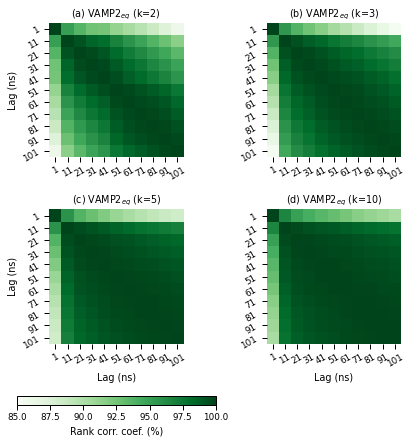

In [19]:
with sns.plotting_context('paper', font_scale=1):
    gs_kw = dict(width_ratios=[1, 1], height_ratios=[3, 3, 0.2], hspace=0.1, wspace=0)
    fig, axd = plt.subplot_mosaic([['top left', 'top right'],
                                   ['bottom left', 'bottom right'], 
                                   ['cbar', '.']],
                                  gridspec_kw=gs_kw, figsize=(6, 6),
                                  constrained_layout=True )
    vmin, vmax = 85, 100
    procs = [2, 3, 5, 10]
    top_n = -1
    for i, lab in enumerate(['top left','top right', 'bottom left', 'bottom right']):
        for j in [0]:
            ax = axd[lab]
            proc = procs[i]
            df = spearmans(vamp_eqs, proc, top_n)
        
            sns.heatmap(df*100, ax=ax, vmin=vmin, vmax=vmax, annot=False, cmap='Greens', cbar=False, 
                        annot_kws=dict(size='small'), square=True, fmt='0.1f')
            if 'bottom' in lab:
                ax.set_xlabel('Lag (ns)')
            else: 
                ax.set_xlabel('')
            if 'left' in lab:
                ax.set_ylabel('Lag (ns)')
            else: 
                ax.set_ylabel('')
            ax.set_title(f"({list('abcd')[i]}) VAMP2$_{{eq}}$ (k={proc})")
            ax.tick_params(axis='x', rotation=30)
            ax.tick_params(axis='y', rotation=30)       
        
    col_map = plt.get_cmap('Greens')
    mpl.colorbar.ColorbarBase(axd['cbar'], cmap=col_map, orientation = 'horizontal', 
                             label='Rank corr. coef. (%)', norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))  
    
    
    
    
#     plt.tight_layout()
    plt.savefig(f'../{protein}/vampeq_rank_vs_lag_all.pdf', bbox_inches='tight')

In [46]:
for proc in procs: 
    df = vamp_eqs.loc[(vamp_eqs.process == proc), ['rank', 'lag', 'hp_ix']]
    lags = np.sort(df.lag.unique())
    col_vars = [fr"Rank ($\tau={x}$)" for x in lags]
    df['lag'] = df['lag'].apply(lambda x: fr"Rank ($\tau={x}$)")
    
    with sns.plotting_context('paper', font_scale=2): 
        sns.pairplot(df.pivot(index='hp_ix', columns='lag', values='rank'), vars=col_vars, corner=True,diag_kind=None)
        
        plt.savefig(f'../{protein}/vampeq_rank_vs_lag_pairplot_k{proc}.pdf', bbox_inches='tight')      
        plt.close()